In [1]:
import tensorflow as tf
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

In [2]:
import os
import numpy as np
import albumentations as A
import cv2
from images_prepare import pre_images
from masks_prepare import pre_masks, pre_splitted_masks
from Segnet_VGG16 import SegNet_VGG16

In [ ]:
# Define paths
base_path = "/Teeth-Segmentation-project/SegNet-VGG16"
data_path = os.path.join(base_path, "Data")

# Load images
resize_shape = (512, 512)
include_zip = False  # Change to True if data is still in the zip file

X, X_sizes = pre_images(resize_shape, data_path)

# Prepare masks
# Y = pre_masks(resize_shape=(512, 512), path=os.path.join(base_path, "Original_Masks"))
Y = pre_splitted_masks(path=os.path.join(base_path, "Custom_Masks"))

# Normalize images and masks
X = np.float32(X / 255.0)
Y = np.float32(Y / 255.0)
    
num_samples = 30
x_train = X[:num_samples, :, :, :]
y_train = Y[:num_samples, :, :, :]
x_test = X[105:, :, :, :]
y_test = Y[105:, :, :, :]

print("Data preparation completed.")

Data preparation completed.


In [4]:
import cv2
import albumentations as A
import numpy as np

# Augmentation pipeline - Similar to the original code
aug = A.Compose([
    A.OneOf([
        A.RandomCrop(width=512, height=512),
        A.PadIfNeeded(min_height=512, min_width=512, p=0.5)
    ], p=0.4),
    
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    
    A.OneOf([
        A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
        A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
    ], p=0.5),
    
    A.ShiftScaleRotate(shift_limit=0.325, scale_limit=0.15, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15, p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, p=0.5),
    A.HorizontalFlip(p=0.25),
    A.Resize(512, 512, interpolation=cv2.INTER_LINEAR)
])

# Initialize augmented data arrays
x_train1 = np.copy(x_train)
y_train1 = np.copy(y_train)

count = 0
while count < 1:  # Apply augmentation 1 time as in the original code
    x_aug2 = np.copy(x_train1)
    y_aug2 = np.copy(y_train1)
    
    for i in range(len(x_train1)):
        # Perform the augmentation for each image and corresponding mask
        augmented = aug(image=x_train1[i, :, :, :], mask=y_train1[i, :, :, :])
        x_aug2[i, :, :, :] = augmented['image']
        y_aug2[i, :, :, :] = augmented['mask']
    
    # Concatenate augmented data to the original dataset
    x_train = np.concatenate((x_train, x_aug2))
    y_train = np.concatenate((y_train, y_aug2))
    
    count += 1  # Increase the counter to limit to 4 rounds

In [5]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [ ]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

#if there is GPU available you can run the Pytorch model (SegNet_pytorch_model.py)

1
NVIDIA GeForce RTX 3060 Laptop GPU


In [9]:
# Create the model
model = SegNet_VGG16(input_shape=(512, 512, 3))

# Display model summary to check layer shapes
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using GPU if available
with tf.device('/GPU:0'):
    model.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test), verbose=1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 64, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,988,993 (80.07 MB)

 Trainable params: 6,271,361 (23.92 MB)

 Non-trainable params: 14,717,632 (56.14 MB)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7748 - loss: 0.5605 - val_accuracy: 0.4856 - val_loss: 1.6348
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8553 - loss: 0.3390 - val_accuracy: 0.8455 - val_loss: 0.3801
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8704 - loss: 0.2728 - val_accuracy: 0.8370 - val_loss: 0.3397
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8679 - loss: 0.2220 - val_accuracy: 0.8506 - val_loss: 0.2488
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8772 - loss: 0.1991 - val_accuracy: 0.8496 - val_loss: 0.2612
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8807 - loss: 0.1850 - val_accuracy: 0.8521 - val_loss: 0.2454
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8783 - loss: 0.1787 - val_accuracy: 0.8404 - val_loss: 0.2346
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8772 - loss: 0.1782 - val_accuracy: 0.8504 - v

In [11]:
# Save the model
model.save('segnet_vgg16_teeth_segmentation_v1.keras')

In [12]:
import tensorflow as tf
import numpy as np

# Define the Dice score metric
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Load the saved model
model = tf.keras.models.load_model('segnet_vgg16_teeth_segmentation_v1.keras')

# Evaluate the model on test data and calculate Dice score
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Apply threshold for binary segmentation

# Calculate Dice score for each test sample
dice_scores = [dice_score(y_test[i], y_pred[i]) for i in range(len(y_test))]
average_dice_score = np.mean(dice_scores)

print("Average Dice Score:", average_dice_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Average Dice Score: 0.8029201


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


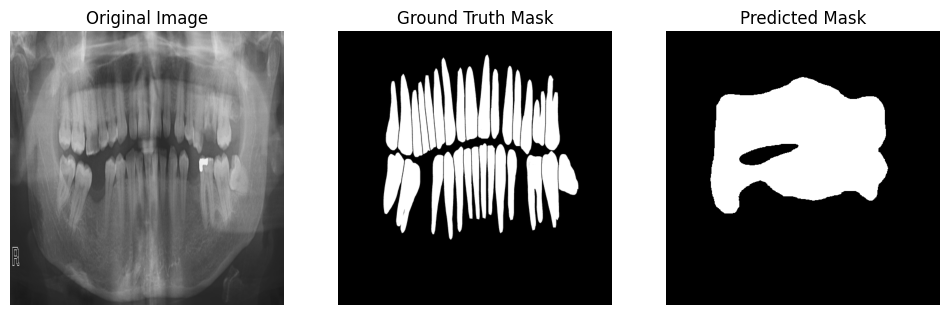

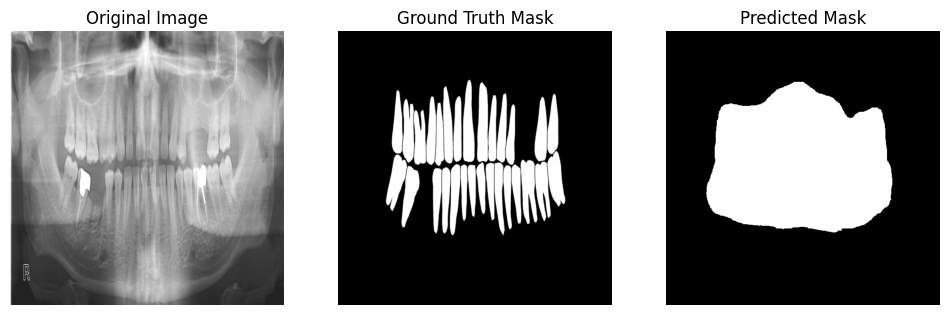

In [13]:
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Apply threshold to get binary predictions

# Choose two sample indices to visualize
sample_indices = [0, 1]  # You can change these indices to visualize different samples

# Plot the original image, ground truth, and predicted mask for each sample
for idx in sample_indices:
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[idx])
    plt.title("Original Image")
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[idx].squeeze(), cmap='gray')  # Squeeze to remove channel dimension for display
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[idx].squeeze(), cmap='gray')  # Squeeze to remove channel dimension for display
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()